In [101]:
import os
# os.getcwd()
os.chdir('C:/Users/19012/Documents/Titans_weekly_previews/visuals/week2_nyj')
os.getcwd()

'C:\\Users\\19012\\Documents\\Titans_weekly_previews\\visuals\\week2_nyj'

> data: https://pypi.org/project/nfl-data-py/

In [102]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import cfbd

import matplotlib.pyplot as plt 

pd.set_option('display.max_columns', 500)

In [103]:
# configuration = cfbd.Configuration()
# configuration.api_key['Authorization'] = 'PiIMSsA5vyFy5GZ6kkal0cJcRxnbALQqyWmHzBK1o/6eV3ZFYk7Nh5+HH4ZIwnfb'
# configuration.api_key_prefix['Authorization'] = 'Bearer'

# api_config = cfbd.ApiClient(configuration)

In [104]:
nfl_weekly = nfl.import_weekly_data([2023])
nfl_pbp = nfl.import_pbp_data([2023], downcast=False, cache=False, alt_path=None)
team_colors = nfl.import_team_desc()
nfl_weekly = nfl_weekly.merge(team_colors[['team_abbr','team_color']],left_on=['recent_team'],right_on=['team_abbr'],how='left')

Downcasting floats.
2023 done.


In [105]:
# pd.set_option('display.max_rows', None)

In [106]:
team_name = ['TEN','NYJ']
offense_defense = ['posteam','defteam']

# Week 2: Tennessee vs New York (Jets)

## Summary

Let's look at high-level stats

In [107]:
nfl_epa_passing = nfl_pbp[(nfl_pbp['pass']==1)].groupby('posteam').\
                                agg({'epa': 'mean'}).\
                                sort_values(by='epa',ascending=False).\
                                reset_index().reset_index()
nfl_epa_passing['percentile'] = 1- (nfl_epa_passing['index'] / max(nfl_epa_passing['index']))
nfl_epa_passing = nfl_epa_passing[nfl_epa_passing['posteam']=='TEN'].reset_index(drop=True).drop('index',axis=1)
# nfl_epa_passing=nfl_epa_passing.drop('index',axis=1)
nfl_epa_passing

,posteam,epa,percentile
0,TEN,0.015721,0.387097


In [108]:
df = pd.DataFrame()
for team in offense_defense:
    for j in team_name:
        nfl_epa_passing = nfl_pbp[(nfl_pbp['pass']==1)].groupby(team).\
                                        agg({'epa': 'mean'}).\
                                        sort_values(by='epa',ascending=False).\
                                        reset_index().reset_index()
        nfl_epa_passing['epa_percentile'] = 1 - (nfl_epa_passing['index'] / max(nfl_epa_passing['index']))
        epa_passing = nfl_epa_passing[nfl_epa_passing[team]==j].reset_index(drop=True).drop('index',axis=1)

        nfl_epa_rushing = nfl_pbp[(nfl_pbp['pass']==0)].groupby(team).\
                                        agg({'epa': 'mean'}).\
                                        sort_values(by='epa',ascending=False).\
                                        reset_index().reset_index()
        nfl_epa_rushing['epa_percentile'] = 1 - (nfl_epa_rushing['index'] / max(nfl_epa_rushing['index']))
        epa_rushing = nfl_epa_rushing[nfl_epa_rushing[team]==j].reset_index(drop=True).drop('index',axis=1)

        nfl_success_passing = nfl_pbp[(nfl_pbp['pass']==1)].groupby(team).\
                                        agg({'success': 'mean'}).\
                                        sort_values(by='success',ascending=False).\
                                        reset_index().reset_index()
        nfl_success_passing['success_percentile'] = 1 - (nfl_success_passing['index'] / max(nfl_success_passing['index']))
        success_passing = nfl_success_passing[nfl_success_passing[team]==j].reset_index(drop=True).drop('index',axis=1)

        nfl_success_rushing = nfl_pbp[(nfl_pbp['pass']==0)].groupby(team).\
                                        agg({'success': 'mean'}).\
                                        sort_values(by='success',ascending=False).\
                                        reset_index().reset_index()
        nfl_success_rushing['success_percentile'] = 1 - (nfl_success_rushing['index'] / max(nfl_success_rushing['index']))
        success_rushing = nfl_success_rushing[nfl_success_rushing[team]==j].reset_index(drop=True).drop('index',axis=1)

        nfl_success_third = nfl_pbp[((nfl_pbp['down']==3))].groupby(team).\
                                        agg({'success': 'mean'}).\
                                        sort_values(by='success',ascending=False).\
                                        reset_index().reset_index()
        nfl_success_third['percentile'] = 1 - (nfl_success_third['index'] / max(nfl_success_third['index']))
        success_third = nfl_success_third[nfl_success_third[team]==j].reset_index(drop=True).drop('index',axis=1)

        nfl_third_dist = nfl_pbp[((nfl_pbp['down']==3))].groupby(team).\
                                        agg({'ydstogo': 'mean'}).\
                                        sort_values(by='ydstogo',ascending=True).\
                                        reset_index().reset_index()
        nfl_third_dist['percentile'] = 1 - (nfl_third_dist['index'] / max(nfl_third_dist['index']))
        third_dist = nfl_third_dist[nfl_third_dist[team]==j].reset_index(drop=True).drop('index',axis=1)

        # get all stats together
        stats = epa_passing.merge(epa_rushing,how='left',on=team,suffixes=('_pass', '_rush'))\
                    .merge(success_passing,how='left',on=team)\
                    .merge(success_rushing,how='left',on=team,suffixes=('_pass', '_rush'))\
                    .merge(success_third,how='left',on=team)\
                    .merge(third_dist,how='left',on=team,suffixes=('_thirdsuccess', '_thirddist'))
        stats = stats.rename(columns={'epa_pass':'EPA/Pass',
                                        'epa_rush':'EPA/Rush',
                                        'success_pass':'Success/Pass',
                                        'success_rush':'Success/Rush',
                                        'success':'3rd Down Success',
                                        'ydstogo':'3rd Down Distance'})
        # unpivot table so the stat names are values
        stats_values = pd.melt(stats[[team,'EPA/Pass','EPA/Rush','Success/Pass','Success/Rush','3rd Down Success','3rd Down Distance']], id_vars=[team], var_name='stat', value_name='value')
        percentiles = pd.melt(stats[[team,'epa_percentile_pass','epa_percentile_rush','success_percentile_pass','success_percentile_rush','percentile_thirdsuccess','percentile_thirddist']], id_vars=[team], var_name='stat', value_name='value')
        conditions = [
            (percentiles['stat']=='epa_percentile_pass'),
            (percentiles['stat']=='epa_percentile_rush'),
            (percentiles['stat']=='success_percentile_pass'),
            (percentiles['stat']=='success_percentile_rush'),
            (percentiles['stat']=='percentile_thirdsuccess'),
            (percentiles['stat']=='percentile_thirddist')
        ]
        choices = ['EPA/Pass', 'EPA/Rush','Success/Pass','Success/Rush','3rd Down Success','3rd Down Distance']
        percentiles['stat'] = np.select(conditions,choices, default=0)
        stats = stats_values.merge(percentiles,how='left',on=[team,'stat'],suffixes=('', '_percentile'))
        df = pd.concat([df, stats], ignore_index=True)
df['value_percentile'] = np.where(df['defteam'].isna(),df['value_percentile'],1-df['value_percentile'])

In [109]:
final_df = df[~df['posteam'].isna()].merge(df[~df['defteam'].isna()], how='left', on='stat', suffixes=('_off', '_def'))
final_df = final_df[final_df['posteam_off']!=final_df['defteam_def']][['posteam_off','value_off','value_percentile_off','stat','value_def','value_percentile_def','defteam_def']]
final_df = final_df.rename(columns={'posteam_off':'Offense',
                    'value_off':'Added',
                    'stat':'Stat',
                    'value_def':'Allowed',
                    'defteam_def':'Defense'})

final_df['Added'] = np.where(final_df['Stat'].str.contains('Success'), 
         (final_df['Added']*100).round(2).astype('str')+'%',
         (final_df['Added']).round(2)
    )
final_df['Allowed'] = np.where(final_df['Stat'].str.contains('Success'), 
         (final_df['Allowed']*100).round(2).astype('str')+'%',
         (final_df['Allowed']).round(2)
    )

final_df = final_df.merge(team_colors[['team_abbr','team_logo_wikipedia']],
        how='left',
        left_on='Offense',
        right_on='team_abbr')
final_df = final_df.merge(team_colors[['team_abbr','team_logo_wikipedia']],
         how='left',
         left_on='Defense',
         right_on='team_abbr',
         suffixes=('_off','_def'))

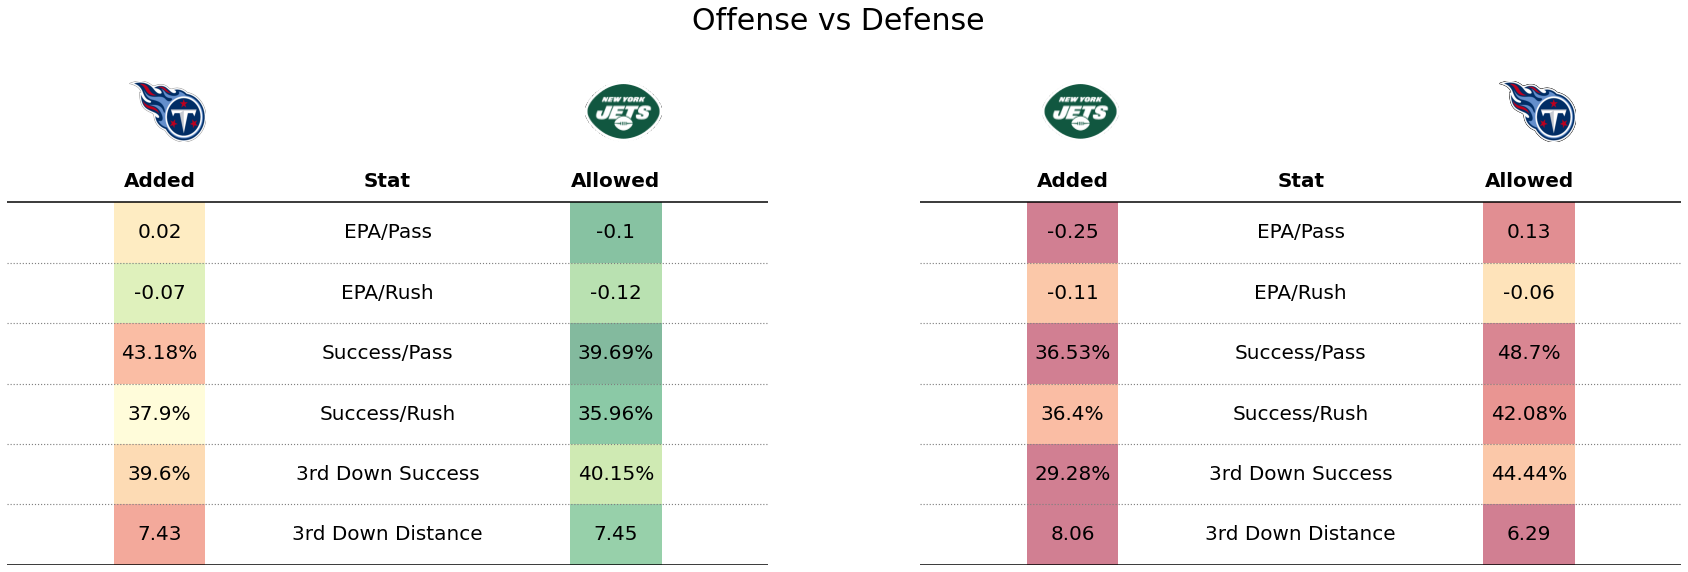

In [110]:
# fig = plt.figure(figsize=(7,5))
# plt.figure(facecolor='#ffff')
# ax = plt.subplot(1,1)
fig, ax = plt.subplots(1,2,figsize=(30,10),facecolor='#ffff')

for table_number,team in enumerate(team_name):
    
    
    plotting_df = final_df[final_df['Offense']==team].\
                        reset_index(drop=True).\
                        sort_index(ascending=False)

    color1 = '#FFFFFF'
    color2 = '#7C4D8B'

#     plotting_df['colors'] = get_color_gradient(color1, color2, len(plotting_df))

    ncols = 5
    nrows = plotting_df.shape[0]

    ax[table_number].set_xlim(0, 0.5)
    ax[table_number].set_ylim(0, nrows+3)

    positions = [0.1, 0.25, 0.4]
    columns = ['Added','Stat','Allowed']

    # Add table's main text
    for i in range(nrows):
        for j, column in enumerate(columns):
            if j == 0:
                ha = 'center'
            else:
                ha = 'center'
            if (column == '') | (column == ''):
                text_label = f'{plotting_df[column].iloc[i]:,.2f}'
                weight = 'bold'
            else:
                text_label = f'{plotting_df[column].iloc[i]}'
                weight = 'normal'
            ax[table_number].annotate(
                xy=(positions[j], i+0.5),
                text=text_label,
                ha=ha,
                va='center',
                weight=weight,
                fontsize=20
            )
        if i == 0:
            a = plt.imread(plotting_df['team_logo_wikipedia_off'][i])
            ax[table_number].imshow(a, extent=[0.08, 0.13, nrows+1, nrows+2], aspect='auto', zorder=2)
            ax[table_number].annotate(
                    xy=(0.45, 3),
                    text='',
                    fontsize=40
                )
        else:
            a = plt.imread(plotting_df['team_logo_wikipedia_def'][i])
            ax[table_number].imshow(a, extent=[0.38, 0.43, nrows+1, nrows+2], aspect='auto', zorder=2)
            ax[table_number].annotate(
                    xy=(0.45, 3),
                    text='',
                    fontsize=40
                )
    # Add column names
    column_names = ['Added','Stat','Allowed']
    for index, c in enumerate(column_names):
            if index == 0:
                ha = 'center'
            else:
                ha = 'center'
            ax[table_number].annotate(
                xy=(positions[index], nrows+.2),
                text=column_names[index],
                ha=ha,
                va='bottom',
                weight='bold',
                fontsize=20
            )
    # ax.text(0.1, 9.75, 'Name', weight='bold', ha='left')
    # ax.text(0.56, 9.75, 'EPA/Play', weight='bold', ha='right')
    # ax.text(0.85, 9.75, 'Snaps', weight='bold', ha='right')
    # Add dividing lines
    ax[table_number].plot([ax[table_number].get_xlim()[0], 
                           ax[table_number].get_xlim()[1]], 
                          [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
    ax[table_number].plot([ax[table_number].get_xlim()[0], 
                           ax[table_number].get_xlim()[1]], 
                          [0, 0], lw=1.5, color='black', marker='', zorder=4)
    for x in range(1, nrows):
        ax[table_number].plot([ax[table_number].get_xlim()[0],
                               ax[table_number].get_xlim()[1]], 
                              [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')
    
    # use tuple for color  
    # loop through the rows for offense
    for i in range(0,nrows):
        ax[table_number].fill_between(
            x=[0.07,0.13],
            y1=i+1,
            y2=i,
            color=plt.cm.RdYlGn(plotting_df['value_percentile_off'][(i-5)*-1]),
            alpha=0.5,
            ec='None'
        )
    # loop through the rows for defense
    for i in range(0,nrows):
        ax[table_number].fill_between(
            x=[0.37,0.43],
            y1=i+1,
            y2=i,
            color=plt.cm.RdYlGn(plotting_df['value_percentile_def'][(i-5)*-1]),
            alpha=0.5,
            ec='None'
        )
    # ax.set_axis_off()

    ax[table_number].set_facecolor('#ffff') 
    plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 
#     ax[0].set_title('Offense vs Defense',loc='left',fontsize=30)
#     ax[1].set_title('Defense vs Offense',loc='left',fontsize=30)
    fig.suptitle('Offense vs Defense',fontsize=30,y=0.9,x=0.51)

    ax[table_number].set_axis_off()
    
plt.savefig(
    './DefenseOffense.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

# color by ranking in league?

## Trenches

Most coaches will tell you the game is won in the trenches, so let's look at stats to which OL/DL contribute. We'll start in the pass game and look at pressures allowed in increments. Let's do it this way because sacks early in the play (<2 sec) should be attributed to OL while sacks later in the play are on the QB. Following that analysis, let's look at the gap analysis of EPA/Play for each gap to find where the holes are in the OL.

### Pass

In [111]:
# sacks vs TTT
# time_to_throw
# sack==1
nfl_pbp[(nfl_pbp['sack']==1) & (nfl_pbp['posteam']=='TEN')][['time_to_throw']].sum()
# can't use TTT with sacks b/c the sacks don't have a TTT

time_to_throw    0.0
dtype: float64

### Rush

In [112]:
df = pd.DataFrame()
for team in offense_defense:
    for j in team_name:
        run_gap = nfl_pbp[(nfl_pbp['pass']==0) & (nfl_pbp['qb_scramble']!=1)].\
            groupby(by=[team,'run_location','run_gap']).\
            agg({'epa':'mean'}).\
            reset_index()

        run_gap['rank'] = run_gap.groupby(by=['run_location','run_gap'])['epa'].rank(method="dense", ascending=False)
        run_gap = run_gap.sort_values(by=['run_location','run_gap','epa'],ascending=False)
        if team=='posteam':
            run_gap['percentile'] = 1 - (run_gap['rank'] / run_gap['rank'].max() )
        else:
            run_gap['percentile'] = (run_gap['rank'] / run_gap['rank'].max() )
        run_gap['epa'] = run_gap['epa'].round(2)
        run_gap['location_gap'] = run_gap['run_location'] + ' ' + run_gap['run_gap']
        run_gap_stats = run_gap.pivot(columns='location_gap',values='epa',index=team).reset_index()
        run_gap_percentiles = run_gap.pivot(columns='location_gap',values='percentile',index=team).reset_index()
        run_gap = run_gap_stats.merge(run_gap_percentiles,on=[team],how='left',suffixes=('_stat','_percentile'))
        run_gap = run_gap[run_gap[team]==j]
        df = pd.concat([df, run_gap], ignore_index=True)

df = df.sort_values(by=['posteam','defteam']).reset_index(drop=True)
df = df.merge(team_colors[['team_abbr','team_logo_wikipedia']],how='left',left_on='posteam',right_on='team_abbr')
df = df.merge(team_colors[['team_abbr','team_logo_wikipedia']],
         how='left',
         left_on='defteam',
         right_on='team_abbr',
         suffixes=('','remove'))
df['team_logo'] = df['team_logo_wikipedia'].fillna('') + df['team_logo_wikipediaremove'].fillna('')
# df = df[['posteam','left end','left guard','left tackle','right end','right guard','right tackle','defteam','team_logo']]
offensedefense = df[1:3]
defenseoffense = df.iloc[[0,3]]
# offensedefense

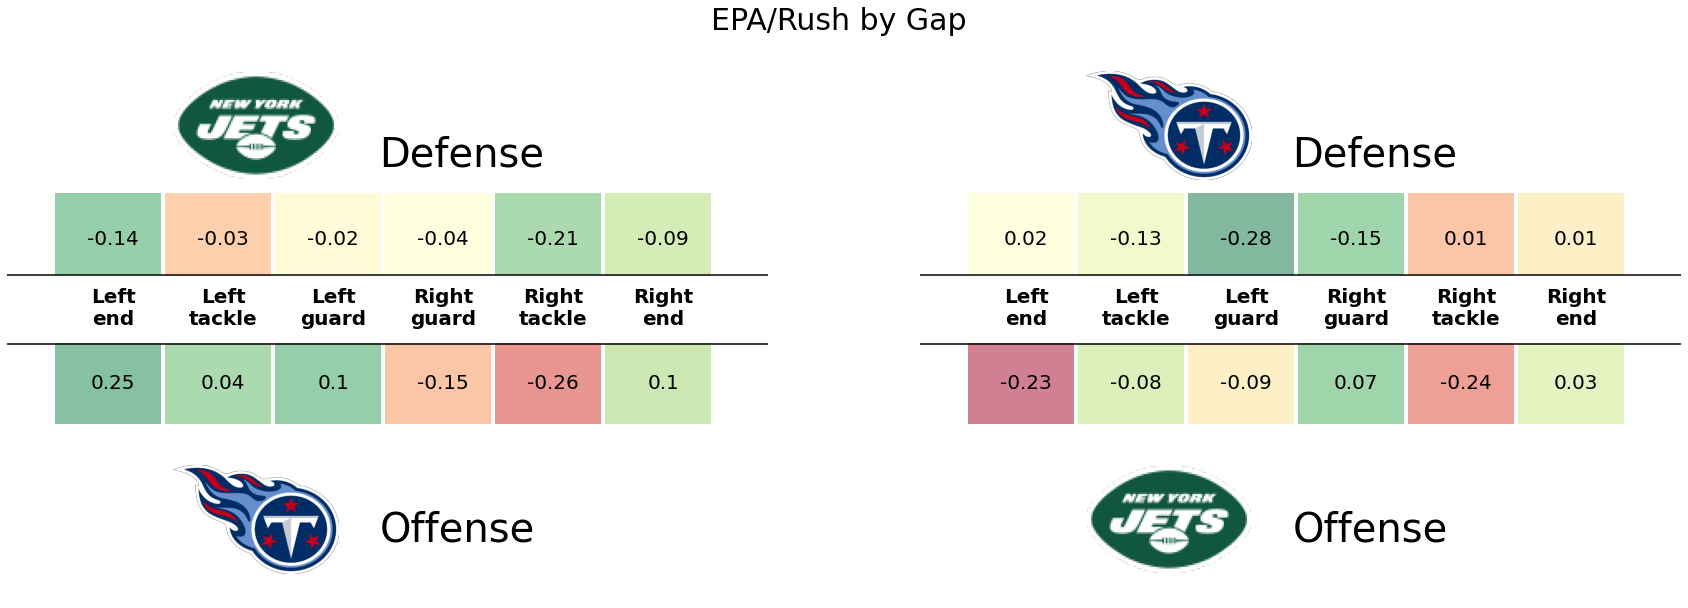

In [113]:
# fig = plt.figure(figsize=(7,5))
# plt.figure(facecolor='#ffff')
# ax = plt.subplot(1,1)
fig, ax = plt.subplots(1,2,figsize=(30,10),facecolor='#ffff')

for table_number,table in enumerate([offensedefense,defenseoffense]):
    
    plotting_df = table.reset_index(drop=True)#.sort_index(ascending=False)
#     plotting_df = df[df['posteam']==team].\
#                         reset_index(drop=True).\
#                         sort_index(ascending=False)
    # plotting_df['Rank'] = 10-plotting_df['Rank']

    color1 = '#FFFFFF'
    color2 = '#7C4D8B'

#     plotting_df['colors'] = get_color_gradient(color1, color2, len(plotting_df))

    ncols = 6
    nrows = plotting_df.shape[0]

    ax[table_number].set_xlim(0, 0.92)
    ax[table_number].set_ylim(1, nrows+1)

    positions = [0.128, 0.261, 0.394, 0.527, 0.66, 0.793]
    columns = ['left end_stat','left tackle_stat','left guard_stat','right guard_stat','right tackle_stat','right end_stat']

    # Add table's main text
    for i in range(nrows):
        for j, column in enumerate(columns):
            text_label = f'{plotting_df[column].iloc[i]}'
            weight = 'normal'
            if i==0:
                ax[table_number].annotate(
                    xy=(positions[j], i+1.8),
                    text=text_label,
                    ha=ha,
                    va='center',
                    weight=weight,
                    fontsize=20
                )
            
            else:
                ax[table_number].annotate(
                    xy=(positions[j], i+1.33),
                    text=text_label,
                    ha=ha,
                    va='center',
                    weight=weight,
                    fontsize=20
                )
        # offense
        if i == 0:
            a = plt.imread(plotting_df['team_logo'][i])
            ax[table_number].imshow(a, extent=[0.2, 0.4, 1.1,1.5], aspect='auto', zorder=2)
            ax[table_number].annotate(
                    xy=(0.45, 1.22),
                    text='Offense',
                    fontsize=40
                )
        # defense
        else:
            a = plt.imread(plotting_df['team_logo'][i])
            ax[table_number].imshow(a, extent=[0.2, 0.4, 2.55,2.95], aspect='auto', zorder=2)
            ax[table_number].annotate(
                    xy=(0.45, 2.6),
                    text='Defense',
                    fontsize=40
                )
    # Add column names
    column_names = ['Left\nend','Left\ntackle','Left\nguard','Right\nguard','Right\ntackle','Right\nend']
    for index, c in enumerate(column_names):
            if index == 0:
                ha = 'center'
            else:
                ha = 'center'
            ax[table_number].annotate(
                xy=(positions[index], nrows),
                text=column_names[index],
                ha=ha,
                va='bottom',
                weight='bold',
                fontsize=20
            )
    # ax.text(0.1, 9.75, 'Name', weight='bold', ha='left')
    # ax.text(0.56, 9.75, 'EPA/Play', weight='bold', ha='right')
    # ax.text(0.85, 9.75, 'Snaps', weight='bold', ha='right')
    # Add dividing lines
    ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [nrows-0.055, nrows-0.055], lw=1.5, color='black', marker='', zorder=4)
    ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [nrows+0.2, nrows+0.2], lw=1.5, color='black', marker='', zorder=4)
#     ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
#     for x in range(1, nrows):
#         ax[table_number].plot([ax[table_number].get_xlim()[0],ax[table_number].get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

    # use tuple for color  
    color_df = table[['left end_percentile','left tackle_percentile','left guard_percentile','right guard_percentile','right tackle_percentile','right end_percentile']].reset_index(drop=True)
    for i,j in enumerate(color_df.columns):
        for rownum in range(0,color_df.iloc[:,i].shape[0]):
            # offense
            if rownum==0:
                ax[table_number].fill_between(
                    x=[positions[i]-0.07,positions[i]+0.058],
#                     y1=rownum+2.5,
#                     y2=rownum+2.2,
                    y1=rownum+1.95,
                    y2=rownum+1.65,
                    color=plt.cm.RdYlGn(color_df.iloc[:,i][rownum]),
                    alpha=0.5,
                    ec='None'
                )
            # defense
            else:
                ax[table_number].fill_between(
                    x=[positions[i]-0.07,positions[i]+0.058],
#                     x=[i/7+0.05,i/7+0.193],
#                     y1=rownum+0.65,
#                     y2=rownum+0.95,
                    y1=rownum+1.2,
                    y2=rownum+1.5,
                    color=plt.cm.RdYlGn(color_df.iloc[:,i][rownum]),
                    alpha=0.5,
                    ec='None'
                )
    ax[table_number].set_facecolor('#ffff') 
    plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 
#     ax[0].set_title('Titans Offense vs Defense',loc='left',fontsize=30)
#     ax[1].set_title('Titans Defense vs Offense',loc='left',fontsize=30)
    fig.suptitle('EPA/Rush by Gap',fontsize=30,y=0.95,x=0.51)

    ax[table_number].set_axis_off()
    
plt.savefig(
    './runGapAnalysis.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

# color by ranking in league?
# add logos above and below numbers

## QB Heatmaps

Find where the QBs were most efficient. Just look at this from the team level to allow for a more robust report.

In [114]:
conditions = [
    (nfl_pbp['air_yards']<=0),
    (nfl_pbp['air_yards']>0) & (nfl_pbp['air_yards']<=5),
    (nfl_pbp['air_yards']>5) & (nfl_pbp['air_yards']<=10),
    (nfl_pbp['air_yards']>10) & (nfl_pbp['air_yards']<=15),
    (nfl_pbp['air_yards']>15) & (nfl_pbp['air_yards']<=20),
    (nfl_pbp['air_yards']>20)
]
choices = ['Behind LOS', '0-5','5-10','10-15','15-20','20+']
nfl_pbp['air_yards_buckets'] = np.select(conditions,choices, default=0)
reorderlist = ['20+',
               '15-20',
               '10-15',
               '5-10',
               '0-5',
              'Behind LOS']

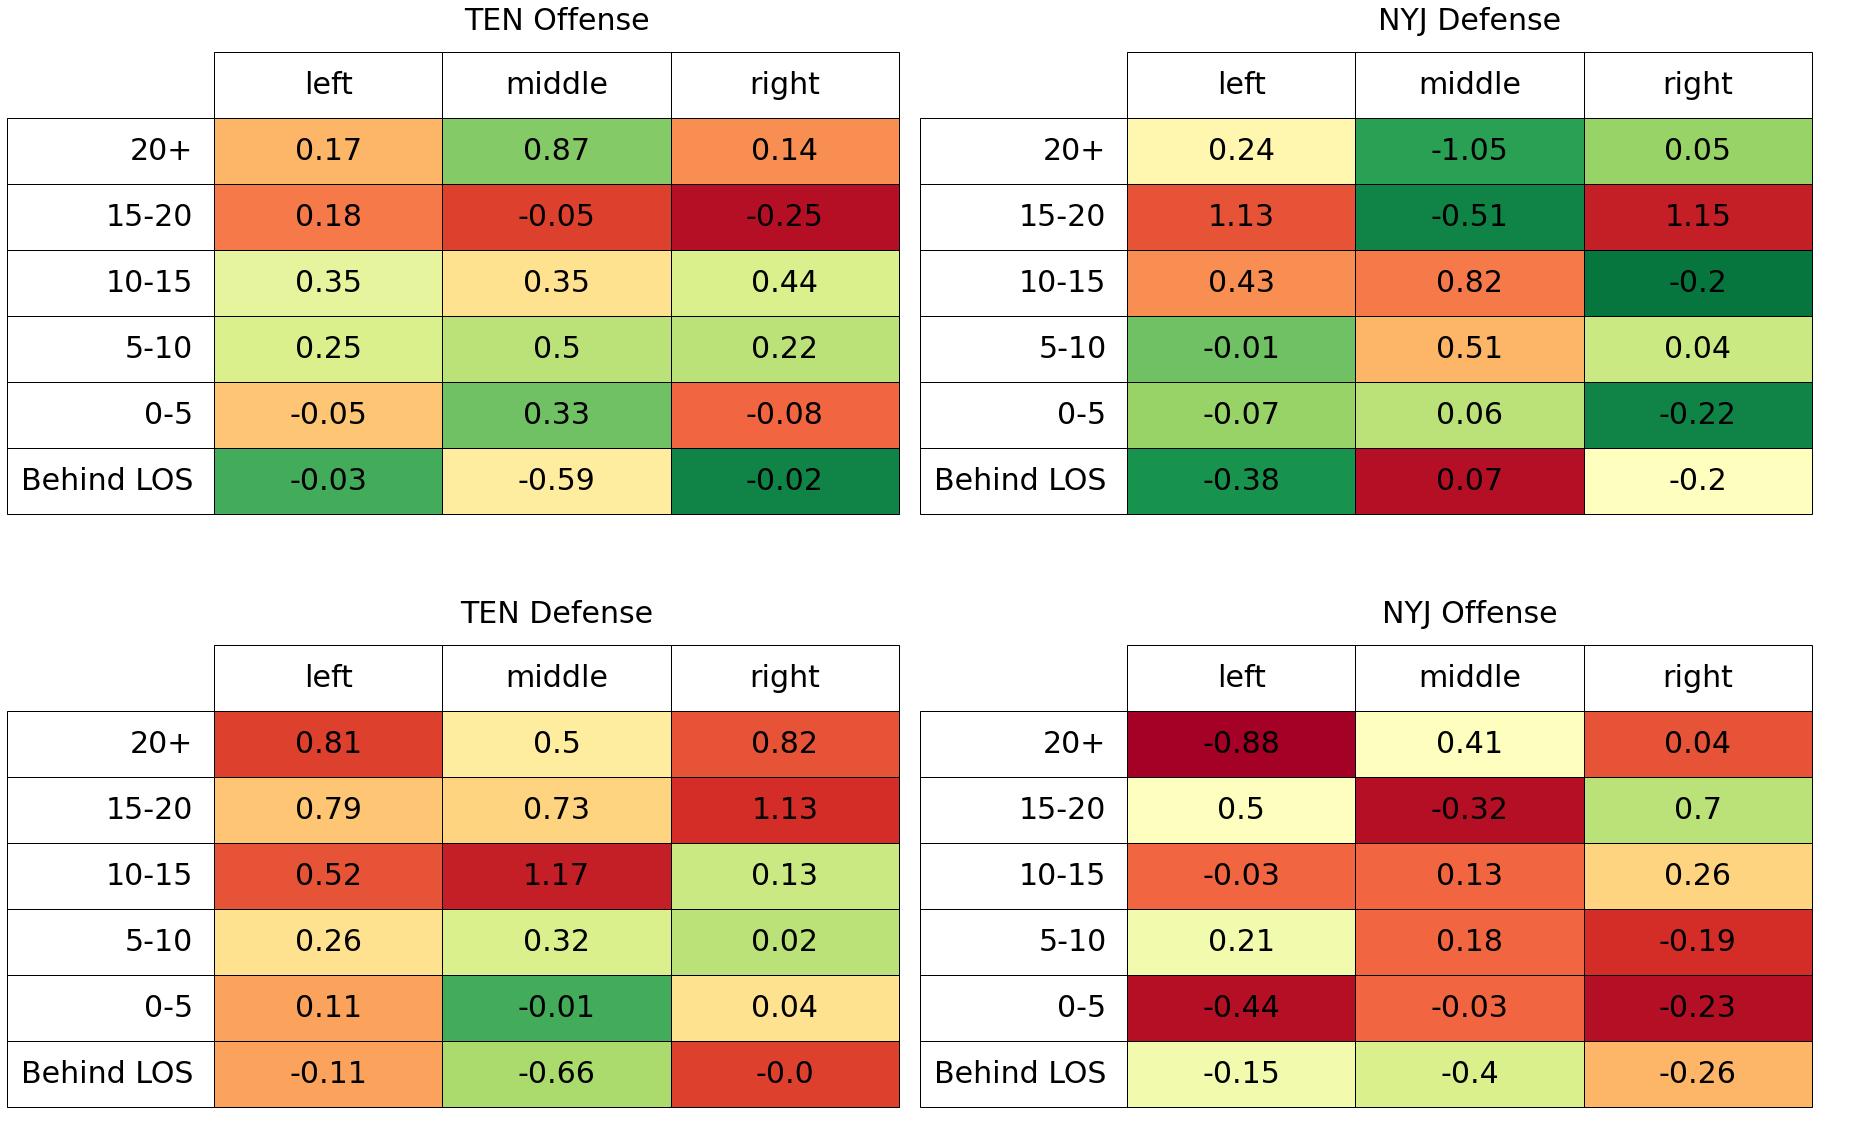

In [115]:
fig, ax = plt.subplots(2,2,figsize=(30,20),facecolor='#ffff')

# for team in team_name:
for team_number,team in enumerate(team_name):
    
    ax[0][team_number].axis('off')
    ax[1][team_number].axis('off')
    
    # offense
    epa_pass_heatmap = nfl_pbp[(nfl_pbp['play_type']=='pass')].\
                            groupby(by=['pass_location','air_yards_buckets','posteam']).\
                            agg({'epa':'mean'}).\
                            sort_values(by=['epa'],ascending=False).\
                            reset_index()
    epa_pass_heatmap['group_rank'] = epa_pass_heatmap.groupby(['pass_location','air_yards_buckets']).cumcount()+1
    epa_pass_heatmap['percentile'] = (32-epa_pass_heatmap['group_rank'])/32
    epa_pass_heatmap_off = epa_pass_heatmap[(epa_pass_heatmap['posteam']==team)]

    pass_heatmap_off_epa = epa_pass_heatmap_off.pivot(columns=['pass_location'],
                                                        index=['air_yards_buckets'],
                                                        values=['epa'])['epa'].reindex(reorderlist)

    pass_heatmap_percentile_off = epa_pass_heatmap_off.pivot(columns=['pass_location'],
                                                              index=['air_yards_buckets'],
                                                              values=['percentile'])['percentile'].reindex(reorderlist)
    
    # defemse
    epa_pass_heatmap = nfl_pbp[(nfl_pbp['play_type']=='pass') ].\
                            groupby(by=['pass_location','air_yards_buckets','defteam']).\
                            agg({'epa':'mean'}).\
                            sort_values(by=['epa']).\
                            reset_index()
    epa_pass_heatmap['group_rank'] = epa_pass_heatmap.groupby(['pass_location','air_yards_buckets']).cumcount()+1
    epa_pass_heatmap['percentile'] = (32-epa_pass_heatmap['group_rank'])/32
    epa_pass_heatmap_def = epa_pass_heatmap[(epa_pass_heatmap['defteam']==team)]

    pass_heatmap_def_epa = epa_pass_heatmap_def.pivot(columns=['pass_location'],
                                                        index=['air_yards_buckets'],
                                                        values=['epa'])['epa'].reindex(reorderlist)

    pass_heatmap_percentile_def = epa_pass_heatmap_def.pivot(columns=['pass_location'],
                                                              index=['air_yards_buckets'],
                                                              values=['percentile'])['percentile'].reindex(reorderlist)

    ax[team_number][team_number].set_title('{} Offense'.format(team),fontsize=30)
    offense = ax[team_number][team_number].table(cellText=np.around(pass_heatmap_off_epa.values,2), 
             rowLabels=pass_heatmap_off_epa.index, 
             colLabels=pass_heatmap_off_epa.columns,
            loc='center',rowLoc='right',cellLoc='center',colLoc='center',
             colWidths=[0.2,0.2,0.2],
            cellColours=plt.cm.RdYlGn(pass_heatmap_percentile_off),animated=True)
    offense.set_fontsize(30)
    offense.scale(1.5, 5.5)
    
    ax[1-team_number][team_number].set_title('{} Defense'.format(team),fontsize=30)
    defense = ax[1-team_number][team_number].table(cellText=np.around(pass_heatmap_def_epa.values,2), 
             rowLabels=pass_heatmap_def_epa.index, 
             colLabels=pass_heatmap_def_epa.columns,
            loc='center',rowLoc='right',cellLoc='center',colLoc='center',
             colWidths=[0.2,0.2,0.2],
            cellColours=plt.cm.RdYlGn(pass_heatmap_percentile_def),animated=True)
    defense.set_fontsize(30)
    defense.scale(1.5, 5.5)

    plt.savefig("./team_passing_heatmaps.png",bbox_inches='tight')

## Pressure-to-Sack

## WR Route/Efficiency

Which routes had the highest frequency and how efficient was each route? Additionally, look at which routes were used against the defenses and which caused the defenses the most trouble

In [116]:
df = pd.DataFrame()
for offensedefense in offense_defense:
    for team in team_name:
        receptions = nfl_pbp[(nfl_pbp[offensedefense]==team) & 
                             (nfl_pbp['play_type']=='pass') & 
                             ~(nfl_pbp['route'].isna())].count()['play_id']
        routes_off = nfl_pbp[nfl_pbp[offensedefense]==team].groupby(by=['route',offensedefense]).agg({'play_id':'count', 
                                                                                        'epa':'mean',
                                                                                        'air_yards':'mean'}).reset_index().rename(columns={'play_id':'receptions'})
        routes_off['route_percent'] = round((routes_off['receptions'] / receptions)*100,2)
        routes_off['epa'] = routes_off['epa'].round(2) 
        df = pd.concat([df, routes_off], ignore_index=True)

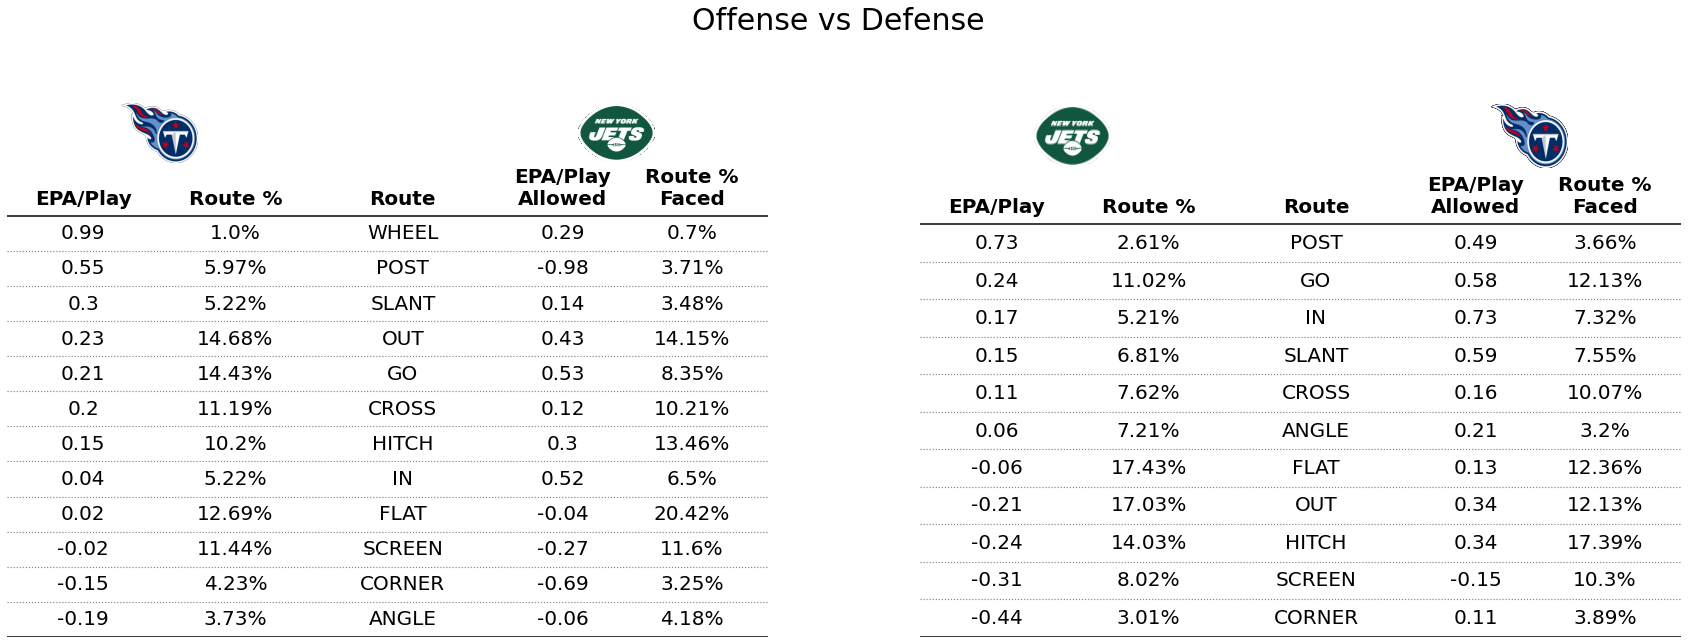

In [117]:
# fig = plt.figure(figsize=(7,5))
# plt.figure(facecolor='#ffff')
# ax = plt.subplot(1,1)
fig, ax = plt.subplots(1,2,figsize=(30,10),facecolor='#ffff')

for table_number,team in enumerate(team_name):
    final_df = df[~df['posteam'].isna()].merge(df[~df['defteam'].isna()], how='left', on='route', suffixes=('_off', '_def'))
    final_df = final_df[final_df['posteam_off']!=final_df['defteam_def']][['posteam_off','epa_off','route_percent_off','route','epa_def','route_percent_def','defteam_def']]
    final_df = final_df.rename(columns={'posteam_off':'Offense',
                        'epa_off':'EPA/Play',
                        'route_percent_off':'Route %',
                        'route':'Route',
                        'route_percent_def':'Route % Faced',
                        'epa_def':'EPA/Play Allowed',
                        'defteam_def':'Defense'})
#     final_df['EPA/Play'] = final_df['EPA/Play'].round(2)
#     final_df['EPA/Play Allowed'] = final_df['EPA/Play Allowed'].round(2)
    final_df['Route %'] = final_df['Route %'].astype('str')+'%'
    final_df['Route % Faced'] = final_df['Route % Faced'].astype('str')+'%'

    final_df = final_df.merge(team_colors[['team_abbr','team_logo_wikipedia']],
            how='left',
            left_on='Offense',
            right_on='team_abbr')
    final_df = final_df.merge(team_colors[['team_abbr','team_logo_wikipedia']],
             how='left',
             left_on='Defense',
             right_on='team_abbr',
             suffixes=('_off','_def'))
    plotting_df = final_df[final_df['Offense']==team].\
                        sort_values(by=['EPA/Play'],ascending=True).\
                        reset_index(drop=True)
    # plotting_df['Rank'] = 10-plotting_df['Rank']

    color1 = '#FFFFFF'
    color2 = '#7C4D8B'

#     plotting_df['colors'] = get_color_gradient(color1, color2, len(plotting_df))

    ncols = 7
    nrows = plotting_df.shape[0]

    ax[table_number].set_xlim(0, 1)
    ax[table_number].set_ylim(0, nrows+3.5)

    positions = [0.1, 0.3, 0.52, 0.73, 0.9]
    columns = ['EPA/Play','Route %','Route','EPA/Play Allowed','Route % Faced']

    # Add table's main text
    for i in range(nrows):
        for j, column in enumerate(columns):
            if j == 0:
                ha = 'center'
            else:
                ha = 'center'
            if (column == '') | (column == ''):
                text_label = f'{plotting_df[column].iloc[i]:,.2f}'
                weight = 'bold'
            else:
                text_label = f'{plotting_df[column].iloc[i]}'
                weight = 'normal'
            ax[table_number].annotate(
                xy=(positions[j], i+0.5),
                text=text_label,
                ha=ha,
                va='center',
                weight=weight,
                fontsize=20
            )
        if i == 0:
            a = plt.imread(plotting_df['team_logo_wikipedia_off'][i])
            ax[table_number].imshow(a, extent=[0.15, 0.25, nrows+1.5, nrows+3.2], aspect='auto', zorder=2)
            ax[table_number].annotate(
                    xy=(0.45, 3),
                    text='',
                    fontsize=40
                )
        else:
            a = plt.imread(plotting_df['team_logo_wikipedia_def'][i])
            ax[table_number].imshow(a, extent=[0.75, 0.85, nrows+1.5, nrows+3.2], aspect='auto', zorder=2)
            ax[table_number].annotate(
                    xy=(0.45, 3),
                    text='',
                    fontsize=40
                )
    # Add column names
    column_names = ['EPA/Play','Route %','Route','EPA/Play\nAllowed','Route %\nFaced']
    for index, c in enumerate(column_names):
            if index == 0:
                ha = 'center'
            else:
                ha = 'center'
            ax[table_number].annotate(
                xy=(positions[index], nrows+.2),
                text=column_names[index],
                ha=ha,
                va='bottom',
                weight='bold',
                fontsize=20
            )
    # ax.text(0.1, 9.75, 'Name', weight='bold', ha='left')
    # ax.text(0.56, 9.75, 'EPA/Play', weight='bold', ha='right')
    # ax.text(0.85, 9.75, 'Snaps', weight='bold', ha='right')
    # Add dividing lines
    ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
    ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
    for x in range(1, nrows):
        ax[table_number].plot([ax[table_number].get_xlim()[0],ax[table_number].get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

    # for i in range(1,nrows+1):
    #     ax[0].fill_between(
    #         x=[0.4,0.6],
    #         y1=i,
    #         y2=i-1,
    #         #color=plotting_df['colors'][i-1],
    #         alpha=0.5,
    #         ec='None'
    #     )
    # ax.set_axis_off()

    ax[table_number].set_facecolor('#ffff') 
    plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 
#     ax[0].set_title('Offense vs Defense',loc='left',fontsize=30)
#     ax[1].set_title('Defense vs Offense',loc='left',fontsize=30)
    fig.suptitle('Offense vs Defense',fontsize=30,y=1,x=0.51)

    ax[table_number].set_axis_off()
    
plt.savefig(
    './routeType.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

# color by ranking in league?
# add in frequency
# replace team name with logo above columns

## Best WRs

Sort WRs by EPA

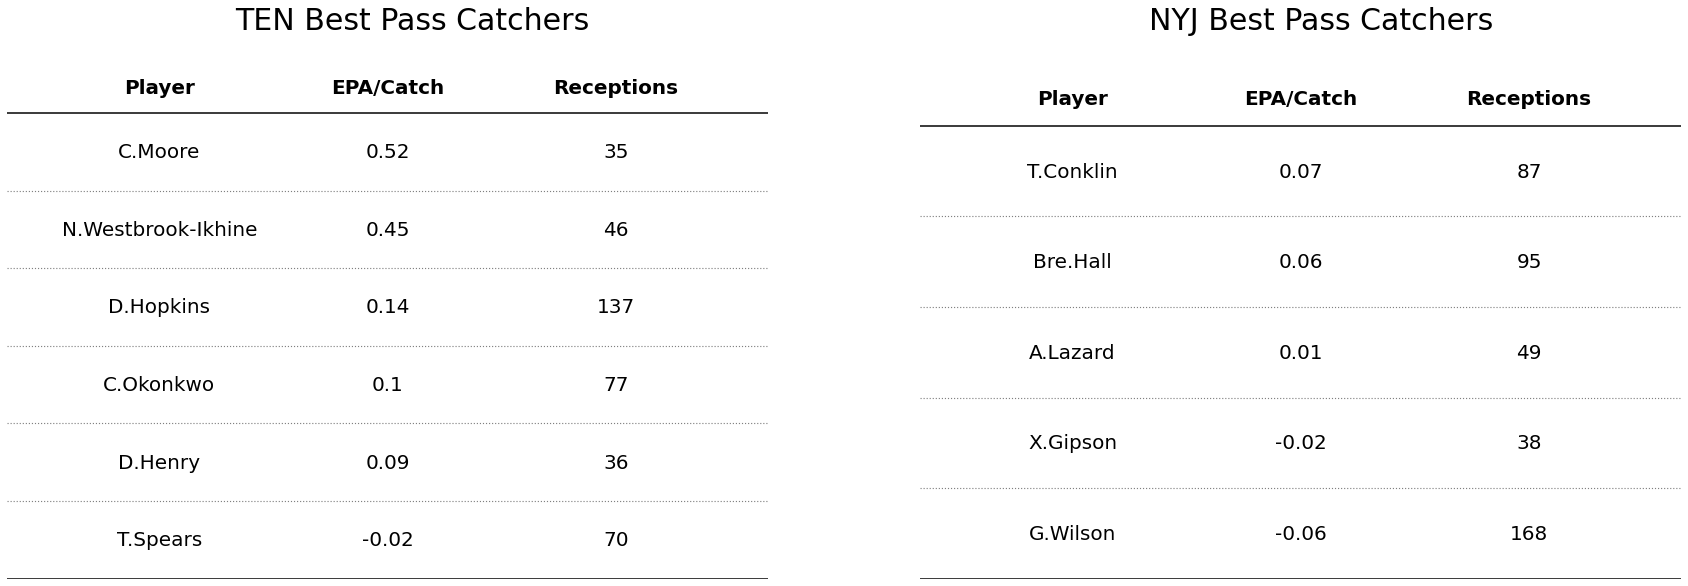

In [118]:
fig, ax = plt.subplots(1,2,figsize=(30,10),facecolor='#ffff')

for table_number,team in enumerate(team_name):
    epa_catch = nfl_pbp[nfl_pbp['posteam']==team].groupby(by='receiver_player_name').agg({'epa':'mean','play_id':'count'})
    epa_catch = epa_catch[epa_catch['play_id']>30].reset_index()
    epa_catch['epa'] = epa_catch['epa'].round(2)
    
    plotting_df = epa_catch.sort_values(by='epa',ascending=True)
    ncols = 3
    nrows = plotting_df.shape[0]

    ax[table_number].set_xlim(0, 1)
    ax[table_number].set_ylim(0, nrows+1)

    positions = [0.2, 0.5, 0.8]
    columns = ['receiver_player_name','epa','play_id']

    # Add table's main text
    for i in range(nrows):
        for j, column in enumerate(columns):
            if j == 0:
                ha = 'center'
            else:
                ha = 'center'
            if (column == '') | (column == ''):
                text_label = f'{plotting_df[column].iloc[i]:,.2f}'
                weight = 'bold'
            else:
                text_label = f'{plotting_df[column].iloc[i]}'
                weight = 'normal'
            ax[table_number].annotate(
                xy=(positions[j], i+0.5),
                text=text_label,
                ha=ha,
                va='center',
                weight=weight,
                fontsize=20
            )
    # Add column names
    column_names = ['Player','EPA/Catch','Receptions']
    for index, c in enumerate(column_names):
            if index == 0:
                ha = 'center'
            else:
                ha = 'center'
            ax[table_number].annotate(
                xy=(positions[index], nrows+.2),
                text=column_names[index],
                ha=ha,
                va='bottom',
                weight='bold',
                fontsize=20
            )
    # ax.text(0.1, 9.75, 'Name', weight='bold', ha='left')
    # ax.text(0.56, 9.75, 'EPA/Play', weight='bold', ha='right')
    # ax.text(0.85, 9.75, 'Snaps', weight='bold', ha='right')
    # Add dividing lines
    ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
    ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
    for x in range(1, nrows):
        ax[table_number].plot([ax[table_number].get_xlim()[0],ax[table_number].get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

    # for i in range(1,nrows+1):
    #     ax[0].fill_between(
    #         x=[0.4,0.6],
    #         y1=i,
    #         y2=i-1,
    #         #color=plotting_df['colors'][i-1],
    #         alpha=0.5,
    #         ec='None'
    #     )
    # ax.set_axis_off()

    ax[table_number].set_facecolor('#ffff') 
    plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 
    ax[table_number].set_title('{} Best Pass Catchers'.format(team),loc='left',fontsize=30,x=0.3)
#     ax[1].set_title('Defense vs Offense',loc='left',fontsize=30)
#     fig.suptitle('Best Pass Catchers',fontsize=30,y=1,x=0.51)

    ax[table_number].set_axis_off()
    
plt.savefig(
    './epaCatch.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

## Best RBs

Sort RBs by EPA

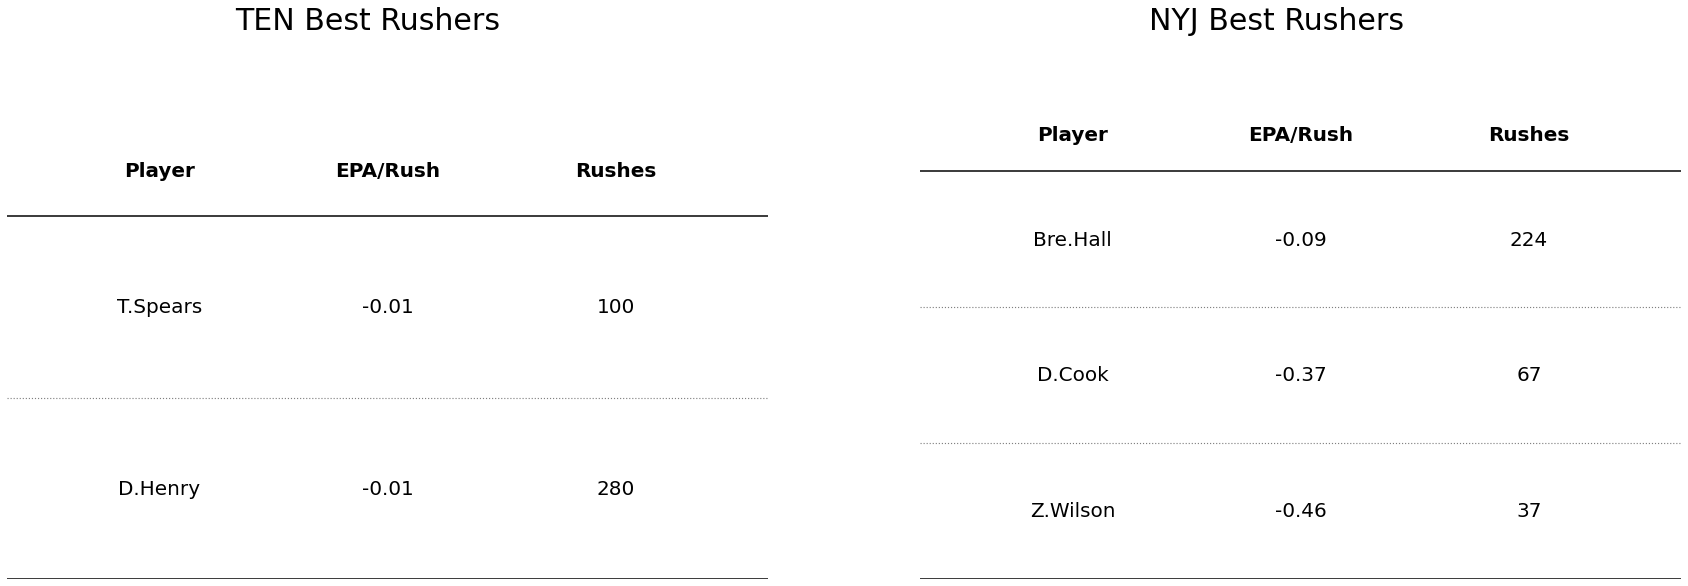

In [119]:
fig, ax = plt.subplots(1,2,figsize=(30,10),facecolor='#ffff')

for table_number,team in enumerate(team_name):
    epa_rush = nfl_pbp[nfl_pbp['posteam']==team].groupby(by='rusher_player_name').agg({'epa':'mean','play_id':'count'})
    epa_rush = epa_rush[epa_rush['play_id']>30].reset_index()
    epa_rush['epa'] = epa_rush['epa'].round(2)
    
    plotting_df = epa_rush.sort_values(by='epa',ascending=True)
    ncols = 3
    nrows = plotting_df.shape[0]

    ax[table_number].set_xlim(0, 1)
    ax[table_number].set_ylim(0, nrows+1)

    positions = [0.2, 0.5, 0.8]
    columns = ['rusher_player_name','epa','play_id']

    # Add table's main text
    for i in range(nrows):
        for j, column in enumerate(columns):
            if j == 0:
                ha = 'center'
            else:
                ha = 'center'
            if (column == '') | (column == ''):
                text_label = f'{plotting_df[column].iloc[i]:,.2f}'
                weight = 'bold'
            else:
                text_label = f'{plotting_df[column].iloc[i]}'
                weight = 'normal'
            ax[table_number].annotate(
                xy=(positions[j], i+0.5),
                text=text_label,
                ha=ha,
                va='center',
                weight=weight,
                fontsize=20
            )
    # Add column names
    column_names = ['Player','EPA/Rush','Rushes']
    for index, c in enumerate(column_names):
            if index == 0:
                ha = 'center'
            else:
                ha = 'center'
            ax[table_number].annotate(
                xy=(positions[index], nrows+.2),
                text=column_names[index],
                ha=ha,
                va='bottom',
                weight='bold',
                fontsize=20
            )
    # ax.text(0.1, 9.75, 'Name', weight='bold', ha='left')
    # ax.text(0.56, 9.75, 'EPA/Play', weight='bold', ha='right')
    # ax.text(0.85, 9.75, 'Snaps', weight='bold', ha='right')
    # Add dividing lines
    ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
    ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
    for x in range(1, nrows):
        ax[table_number].plot([ax[table_number].get_xlim()[0],ax[table_number].get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

    # for i in range(1,nrows+1):
    #     ax[0].fill_between(
    #         x=[0.4,0.6],
    #         y1=i,
    #         y2=i-1,
    #         #color=plotting_df['colors'][i-1],
    #         alpha=0.5,
    #         ec='None'
    #     )
    # ax.set_axis_off()

    ax[table_number].set_facecolor('#ffff') 
    plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 
    ax[table_number].set_title('{} Best Rushers'.format(team),loc='left',fontsize=30,x=0.3)
#     ax[1].set_title('Defense vs Offense',loc='left',fontsize=30)
#     fig.suptitle('Best Pass Catchers',fontsize=30,y=1,x=0.51)

    ax[table_number].set_axis_off()
    
plt.savefig(
    './epaRush.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

## Personnel

In [120]:
df = pd.DataFrame()
for offensedefense in offense_defense:
    for team in team_name:
        formation = nfl_pbp[nfl_pbp[offensedefense]==team].\
                                groupby(by=[offensedefense,'offense_personnel']).\
                                agg({'epa':'mean','play_id':'count'}).reset_index()
        play_count = nfl_pbp[nfl_pbp[offensedefense]==team].\
                                groupby(by=[offensedefense]).\
                                agg({'play_id':'count'})['play_id'][0]
#         formation = formation[(formation['play_type'].isin(['pass','run']))]
#         formation = formation.pivot(columns=['play_type'],values=['epa'],index=[offensedefense,'offense_personnel'])['epa'].reset_index()
#         formation = formation.merge(play_count,on=[offensedefense,'offense_personnel'],how='left')
        formation['personnel_frequency'] = formation['play_id'] / play_count
        df = pd.concat([df, formation], ignore_index=True)

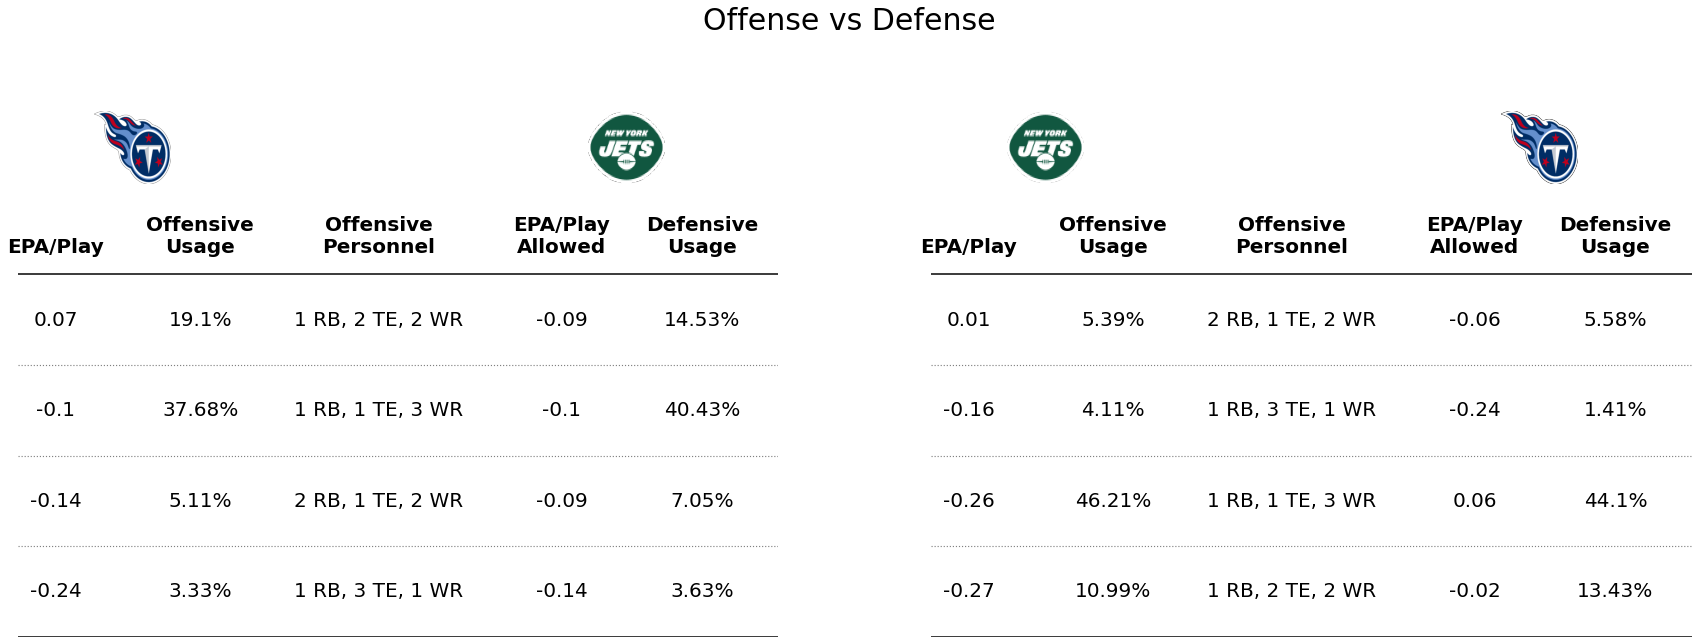

In [121]:
fig, ax = plt.subplots(1,2,figsize=(30,10),facecolor='#ffff')

for table_number,team in enumerate(team_name):
    final_df = df[~df['posteam'].isna()].merge(df[~df['defteam'].isna()], how='left', on='offense_personnel', suffixes=('_off', '_def'))    
    final_df = final_df[final_df['posteam_off']!=final_df['defteam_def']][['posteam_off','epa_off','personnel_frequency_off','offense_personnel','epa_def','personnel_frequency_def','defteam_def']]
    # final_df = final_df[final_df['play_id_off']>40]
    final_df = final_df.rename(columns={'posteam_off':'Offense',
                        'epa_off':'EPA/Play',
                        'personnel_frequency_off':'Offensive Usage',
                        'offense_personnel':'Offensive Personnel',
                        'epa_def':'EPA/Play Allowed',
                        'personnel_frequency_def':'Defensive Usage',
                        'defteam_def':'Defense'})
    final_df['EPA/Play'] = final_df['EPA/Play'].round(2)
    final_df['EPA/Play Allowed'] = final_df['EPA/Play Allowed'].round(2)
    final_df['Offensive Usage'] = ((final_df['Offensive Usage']*100).round(2)).astype('str')+'%'
    final_df['Defensive Usage'] = ((final_df['Defensive Usage']*100).round(2)).astype('str')+'%'

    final_df = final_df.merge(team_colors[['team_abbr','team_logo_wikipedia']],
            how='left',
            left_on='Offense',
            right_on='team_abbr')
    final_df = final_df.merge(team_colors[['team_abbr','team_logo_wikipedia']],
             how='left',
             left_on='Defense',
             right_on='team_abbr',
             suffixes=('_off','_def'))

    plotting_df = final_df[final_df['Offense']==team].\
                    sort_values(by=['Offensive Usage'],ascending=False).\
                    reset_index(drop=True).iloc[:4].sort_values(by='EPA/Play')
    ncols = 7
    nrows = plotting_df.shape[0]

    ax[table_number].set_xlim(0, 2)
    ax[table_number].set_ylim(0, nrows+2)

    positions = [0.1, 0.48, 0.95, 1.43, 1.8]
    columns = ['EPA/Play','Offensive Usage','Offensive Personnel','EPA/Play Allowed','Defensive Usage']

    # Add table's main text
    for i in range(nrows):
        for j, column in enumerate(columns):
            if j == 0:
                ha = 'center'
            else:
                ha = 'center'
            if (column == '') | (column == ''):
                text_label = f'{plotting_df[column].iloc[i]:,.2f}'
                weight = 'bold'
            else:
                text_label = f'{plotting_df[column].iloc[i]}'
                weight = 'normal'
            ax[table_number].annotate(
                xy=(positions[j], i+0.5),
                text=text_label,
                ha=ha,
                va='center',
                weight=weight,
                fontsize=20
            )
        if i == 0:
            a = plt.imread(plotting_df['team_logo_wikipedia_off'][i])
            ax[table_number].imshow(a, extent=[0.2, 0.4, nrows+1, nrows+1.8], aspect='auto', zorder=2)
            ax[table_number].annotate(
                    xy=(0.45, 3),
                    text='',
                    fontsize=40
                )
        else:
            a = plt.imread(plotting_df['team_logo_wikipedia_def'][i])
            ax[table_number].imshow(a, extent=[1.5, 1.7, nrows+1, nrows+1.8], aspect='auto', zorder=2)
            ax[table_number].annotate(
                    xy=(0.45, 3),
                    text='',
                    fontsize=40
                )
    # Add column names
    column_names = ['EPA/Play','Offensive\nUsage','Offensive\nPersonnel','EPA/Play\nAllowed','Defensive\nUsage']
    for index, c in enumerate(column_names):
            if index == 0:
                ha = 'center'
            else:
                ha = 'center'
            ax[table_number].annotate(
                xy=(positions[index], nrows+.2),
                text=column_names[index],
                ha=ha,
                va='bottom',
                weight='bold',
                fontsize=20
            )
    # ax.text(0.1, 9.75, 'Name', weight='bold', ha='left')
    # ax.text(0.56, 9.75, 'EPA/Play', weight='bold', ha='right')
    # ax.text(0.85, 9.75, 'Snaps', weight='bold', ha='right')
    # Add dividing lines
    ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
    ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
    for x in range(1, nrows):
        ax[table_number].plot([ax[table_number].get_xlim()[0],ax[table_number].get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

    # for i in range(1,nrows+1):
    #     ax[0].fill_between(
    #         x=[0.4,0.6],
    #         y1=i,
    #         y2=i-1,
    #         #color=plotting_df['colors'][i-1],
    #         alpha=0.5,
    #         ec='None'
    #     )
    # ax.set_axis_off()

    ax[table_number].set_facecolor('#ffff') 
    plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 
#     ax[table_number].set_title('{} Best Rushers'.format(team),loc='left',fontsize=30,x=0.3)
#     ax[1].set_title('Defense vs Offense',loc='left',fontsize=30)
    fig.suptitle('Offense vs Defense',fontsize=30,y=1,x=0.51)

    ax[table_number].set_axis_off()
    
plt.savefig(
    './offensePersonnel.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

## Coverage Success Offense/Defense

In [122]:
df = pd.DataFrame()
for offensedefense in offense_defense:
    for team in team_name:
        total_plays = nfl_pbp[(nfl_pbp['play_type']=='pass') & 
                           (nfl_pbp[offensedefense]==team)]['play_id'].count()
        coverage = nfl_pbp[(nfl_pbp['play_type']=='pass') & 
                           (nfl_pbp[offensedefense]==team)].groupby(by=[offensedefense,'defense_coverage_type']).agg({'epa':'mean','play_id':'count'}).reset_index()
        coverage['percent'] = coverage['play_id'] / total_plays
        df = pd.concat([df, coverage], ignore_index=True)

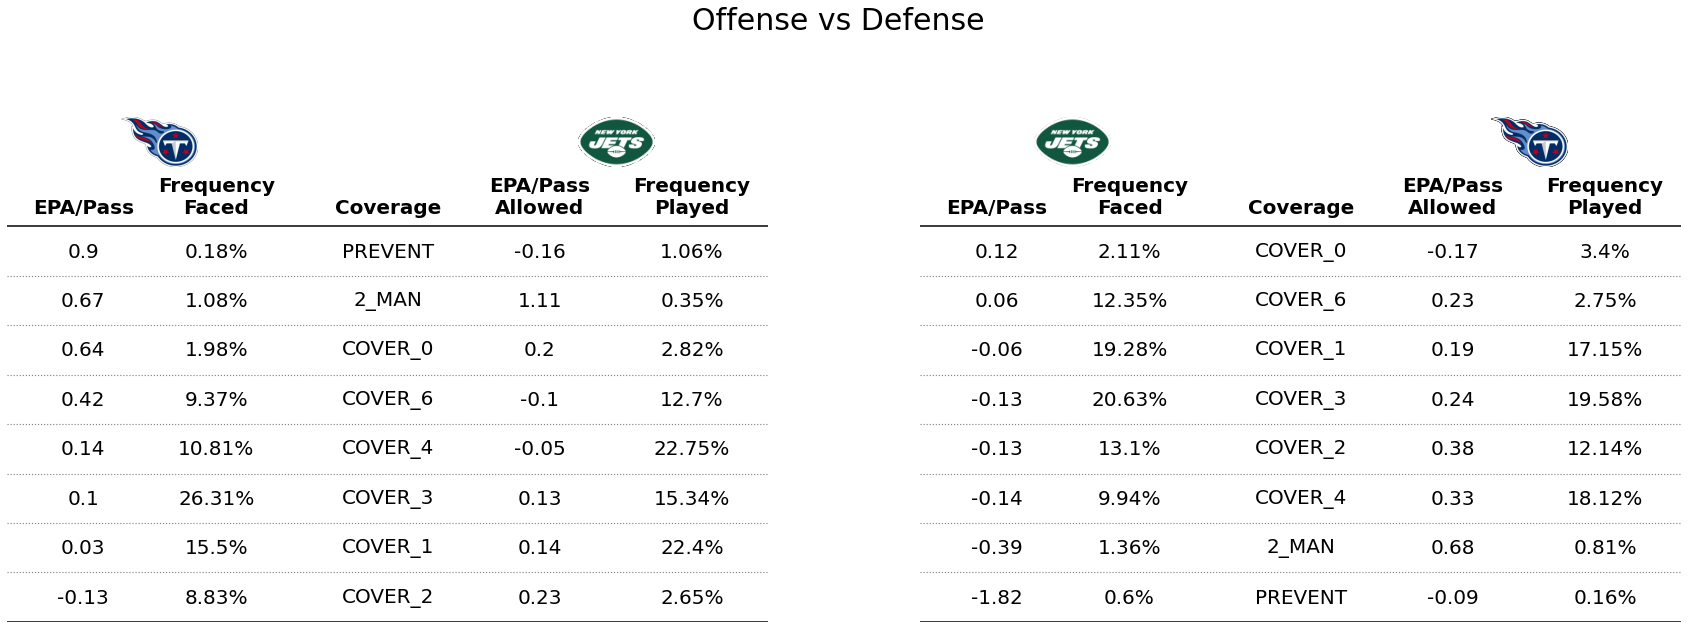

In [123]:
fig, ax = plt.subplots(1,2,figsize=(30,10),facecolor='#ffff')

for table_number,team in enumerate(team_name):
    final_df = df[~df['posteam'].isna()].merge(df[~df['defteam'].isna()], how='left', on='defense_coverage_type', suffixes=('_off', '_def'))
    final_df = final_df[final_df['posteam_off']!=final_df['defteam_def']][['posteam_off','epa_off','percent_off','defense_coverage_type','epa_def','percent_def','defteam_def']]
    final_df = final_df.rename(columns={'posteam_off':'Offense',
                        'epa_off':'EPA/Pass',
                        'percent_off':'Frequency Faced',
                        'defense_coverage_type':'Coverage',
                        'epa_def':'EPA/Pass Allowed',
                        'percent_def':'Frequency Played',
                        'defteam_def':'Defense'})
    final_df['EPA/Pass'] = final_df['EPA/Pass'].round(2)
    final_df['EPA/Pass Allowed'] = final_df['EPA/Pass Allowed'].round(2)
    final_df['Frequency Faced'] = (final_df['Frequency Faced'] * 100).round(2).astype('str')+'%'
    final_df['Frequency Played'] = (final_df['Frequency Played'] * 100).round(2).astype('str')+'%'
    
    final_df = final_df.merge(team_colors[['team_abbr','team_logo_wikipedia']],
                        how='left',
                        left_on='Offense',
                        right_on='team_abbr')
    final_df = final_df.merge(team_colors[['team_abbr','team_logo_wikipedia']],
             how='left',
             left_on='Defense',
             right_on='team_abbr',
             suffixes=('_off','_def'))

    plotting_df = final_df[final_df['Offense']==team].sort_values(by='EPA/Pass',ascending=True).reset_index(drop=True)
    
    ncols = 7
    nrows = plotting_df.shape[0]

    ax[table_number].set_xlim(0, 2)
    ax[table_number].set_ylim(0, nrows+3)

    positions = [0.2, 0.55, 1, 1.4, 1.8]
    columns = ['EPA/Pass','Frequency Faced','Coverage','EPA/Pass Allowed','Frequency Played']

    # Add table's main text
    for i in range(nrows):
        for j, column in enumerate(columns):
            if j == 0:
                ha = 'center'
            else:
                ha = 'center'
            if (column == '') | (column == ''):
                text_label = f'{plotting_df[column].iloc[i]:,.2f}'
                weight = 'bold'
            else:
                text_label = f'{plotting_df[column].iloc[i]}'
                weight = 'normal'
            ax[table_number].annotate(
                xy=(positions[j], i+0.5),
                text=text_label,
                ha=ha,
                va='center',
                weight=weight,
                fontsize=20
            )
        if i == 0:
            a = plt.imread(plotting_df['team_logo_wikipedia_off'][i])
            ax[table_number].imshow(a, extent=[0.3, 0.5, 9.2, 10.2], aspect='auto', zorder=2)
            ax[table_number].annotate(
                    xy=(0.45, 3),
                    text='',
                    fontsize=40
                )
        else:
            a = plt.imread(plotting_df['team_logo_wikipedia_def'][i])
            ax[table_number].imshow(a, extent=[1.5, 1.7, 9.2, 10.2], aspect='auto', zorder=2)
            ax[table_number].annotate(
                    xy=(0.45, 3),
                    text='',
                    fontsize=40
                )
    # Add column names
    column_names = ['EPA/Pass','Frequency\nFaced','Coverage','EPA/Pass\nAllowed','Frequency\nPlayed']
    for index, c in enumerate(column_names):
            if index == 0:
                ha = 'center'
            else:
                ha = 'center'
            ax[table_number].annotate(
                xy=(positions[index], nrows+.2),
                text=column_names[index],
                ha=ha,
                va='bottom',
                weight='bold',
                fontsize=20
            )
        
    # ax.text(0.1, 9.75, 'Name', weight='bold', ha='left')
    # ax.text(0.56, 9.75, 'EPA/Play', weight='bold', ha='right')
    # ax.text(0.85, 9.75, 'Snaps', weight='bold', ha='right')
    # Add dividing lines
    ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
    ax[table_number].plot([ax[table_number].get_xlim()[0], ax[table_number].get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
    for x in range(1, nrows):
        ax[table_number].plot([ax[table_number].get_xlim()[0],ax[table_number].get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

    # for i in range(1,nrows+1):
    #     ax[0].fill_between(
    #         x=[0.4,0.6],
    #         y1=i,
    #         y2=i-1,
    #         #color=plotting_df['colors'][i-1],
    #         alpha=0.5,
    #         ec='None'
    #     )
    # ax.set_axis_off()

    ax[table_number].set_facecolor('#ffff') 
    plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 
#     ax[table_number].set_title('{} Best Rushers'.format(team),loc='left',fontsize=30,x=0.3)
#     ax[1].set_title('Defense vs Offense',loc='left',fontsize=30)
    fig.suptitle('Offense vs Defense',fontsize=30,y=0.98,x=0.51)

    ax[table_number].set_axis_off()
    
plt.savefig(
    './coverage.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

# Blitz Analysis

Table:

Pressure Allowed % | Frequency Faced % | Avg Dist to 1st | Blitz # | Pressure % | Usage % | Avg Dist to 1st

In [124]:
df = pd.DataFrame()
for offensedefense in offense_defense:
    for team in team_name:
        blitz_package = nfl_pbp[(nfl_pbp['play_type']=='pass') & (nfl_pbp[offensedefense]==team)].\
                            groupby(by=[offensedefense,'number_of_pass_rushers'],as_index=False).\
                            agg({'play_id':'count','was_pressure':'mean','ydstogo':'mean','epa':'mean'})
        total_passes = nfl_pbp[(nfl_pbp['play_type']=='pass') & (nfl_pbp[offensedefense]==team)].\
                            groupby(by=[offensedefense],as_index=False).\
                            agg({'play_id':'count'})
        blitz_package = blitz_package.\
                            merge(total_passes,on=offensedefense,how='left')
        blitz_package['blitz_percent'] = blitz_package['play_id_x'] / blitz_package['play_id_y']
        df = pd.concat([df, blitz_package], ignore_index=True)
df

,posteam,number_of_pass_rushers,play_id_x,was_pressure,ydstogo,epa,play_id_y,blitz_percent,defteam
0,TEN,1.0,1,0.000000,1.000000,0.904889,555,0.001802,NaN
1,TEN,3.0,14,0.214286,10.500000,0.269987,555,0.025225,NaN
2,TEN,4.0,303,0.313653,9.310231,-0.058692,555,0.545946,NaN
3,TEN,5.0,104,0.402174,8.653846,-0.089562,555,0.187387,NaN
4,TEN,6.0,32,0.500000,7.093750,-0.122537,555,0.057658,NaN
5,TEN,7.0,6,0.333333,6.000000,1.226399,555,0.010811,NaN
6,TEN,8.0,1,1.000000,8.000000,-1.482461,555,0.001802,NaN
7,NYJ,3.0,13,0.153846,10.461538,0.257970,664,0.019578,NaN
8,NYJ,4.0,413,0.297587,9.714286,-0.331346,664,0.621988,NaN
9,NYJ,5.0,131,0.469027,8.244275,-0.300864,664,0.197289,NaN


In [125]:
final_df = df[(~df['posteam'].isna())].merge(df[~df['defteam'].isna()], how='left', on='number_of_pass_rushers', suffixes=('_off', '_def'))
final_df = final_df[(~final_df['posteam_off'].isna()) & (~final_df['defteam_def'].isna())][final_df['posteam_off']!=final_df['defteam_def']][['posteam_off','was_pressure_off','ydstogo_off','epa_off','blitz_percent_off','number_of_pass_rushers','defteam_def','was_pressure_def','ydstogo_def','epa_def','blitz_percent_def']]

final_df['was_pressure_off'] = (final_df['was_pressure_off']*100).round(2).astype('str')+'%'
final_df['was_pressure_def'] = (final_df['was_pressure_def']*100).round(2).astype('str')+'%'
final_df['ydstogo_off'] = final_df['ydstogo_off'].round(2)
final_df['ydstogo_def'] = final_df['ydstogo_off'].round(2)
final_df['epa_def'] = final_df['epa_def'].round(2)
final_df['epa_off'] = final_df['epa_off'].round(2)
final_df['blitz_percent_off'] = (final_df['blitz_percent_off']*100).round(2).astype('str')+'%'
final_df['blitz_percent_def'] = (final_df['blitz_percent_def']*100).round(2).astype('str')+'%'

final_df = final_df.merge(team_colors[['team_abbr','team_logo_wikipedia']],
        how='left',
        left_on='posteam_off',
        right_on='team_abbr')
final_df = final_df.merge(team_colors[['team_abbr','team_logo_wikipedia']],
         how='left',
         left_on='defteam_def',
         right_on='team_abbr',
         suffixes=('_off','_def'))
final_df

<ipython-input-125-bebbeb9a346d>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_df = final_df[(~final_df['posteam_off'].isna()) & (~final_df['defteam_def'].isna())][final_df['posteam_off']!=final_df['defteam_def']][['posteam_off','was_pressure_off','ydstogo_off','epa_off','blitz_percent_off','number_of_pass_rushers','defteam_def','was_pressure_def','ydstogo_def','epa_def','blitz_percent_def']]


,posteam_off,was_pressure_off,ydstogo_off,epa_off,blitz_percent_off,number_of_pass_rushers,defteam_def,was_pressure_def,ydstogo_def,epa_def,blitz_percent_def,team_abbr_off,team_logo_wikipedia_off,team_abbr_def,team_logo_wikipedia_def
0,TEN,21.43%,10.50,0.27,2.52%,3.0,NYJ,23.81%,10.50,0.24,4.06%,TEN,https://github.com/nflverse/nflverse-pbp/raw/m...,NYJ,https://upload.wikimedia.org/wikipedia/en/thum...
1,TEN,31.37%,9.31,-0.06,54.59%,4.0,NYJ,30.88%,9.31,-0.10,66.84%,TEN,https://github.com/nflverse/nflverse-pbp/raw/m...,NYJ,https://upload.wikimedia.org/wikipedia/en/thum...
2,TEN,40.22%,8.65,-0.09,18.74%,5.0,NYJ,50.0%,8.65,-0.00,11.29%,TEN,https://github.com/nflverse/nflverse-pbp/raw/m...,NYJ,https://upload.wikimedia.org/wikipedia/en/thum...
3,TEN,50.0%,7.09,-0.12,5.77%,6.0,NYJ,66.67%,7.09,-0.23,3.88%,TEN,https://github.com/nflverse/nflverse-pbp/raw/m...,NYJ,https://upload.wikimedia.org/wikipedia/en/thum...
4,TEN,33.33%,6.00,1.23,1.08%,7.0,NYJ,75.0%,6.00,-1.53,0.71%,TEN,https://github.com/nflverse/nflverse-pbp/raw/m...,NYJ,https://upload.wikimedia.org/wikipedia/en/thum...
5,NYJ,15.38%,10.46,0.26,1.96%,3.0,TEN,21.43%,10.46,0.81,2.59%,NYJ,https://upload.wikimedia.org/wikipedia/en/thum...,TEN,https://github.com/nflverse/nflverse-pbp/raw/m...
6,NYJ,29.76%,9.71,-0.33,62.2%,4.0,TEN,28.61%,9.71,0.08,59.06%,NYJ,https://upload.wikimedia.org/wikipedia/en/thum...,TEN,https://github.com/nflverse/nflverse-pbp/raw/m...
7,NYJ,46.9%,8.24,-0.30,19.73%,5.0,TEN,39.47%,8.24,0.18,13.92%,NYJ,https://upload.wikimedia.org/wikipedia/en/thum...,TEN,https://github.com/nflverse/nflverse-pbp/raw/m...
8,NYJ,56.0%,9.45,0.11,4.37%,6.0,TEN,45.83%,9.45,-0.68,4.37%,NYJ,https://upload.wikimedia.org/wikipedia/en/thum...,TEN,https://github.com/nflverse/nflverse-pbp/raw/m...
9,NYJ,20.0%,5.83,-0.07,0.9%,7.0,TEN,75.0%,5.83,0.36,0.65%,NYJ,https://upload.wikimedia.org/wikipedia/en/thum...,TEN,https://github.com/nflverse/nflverse-pbp/raw/m...


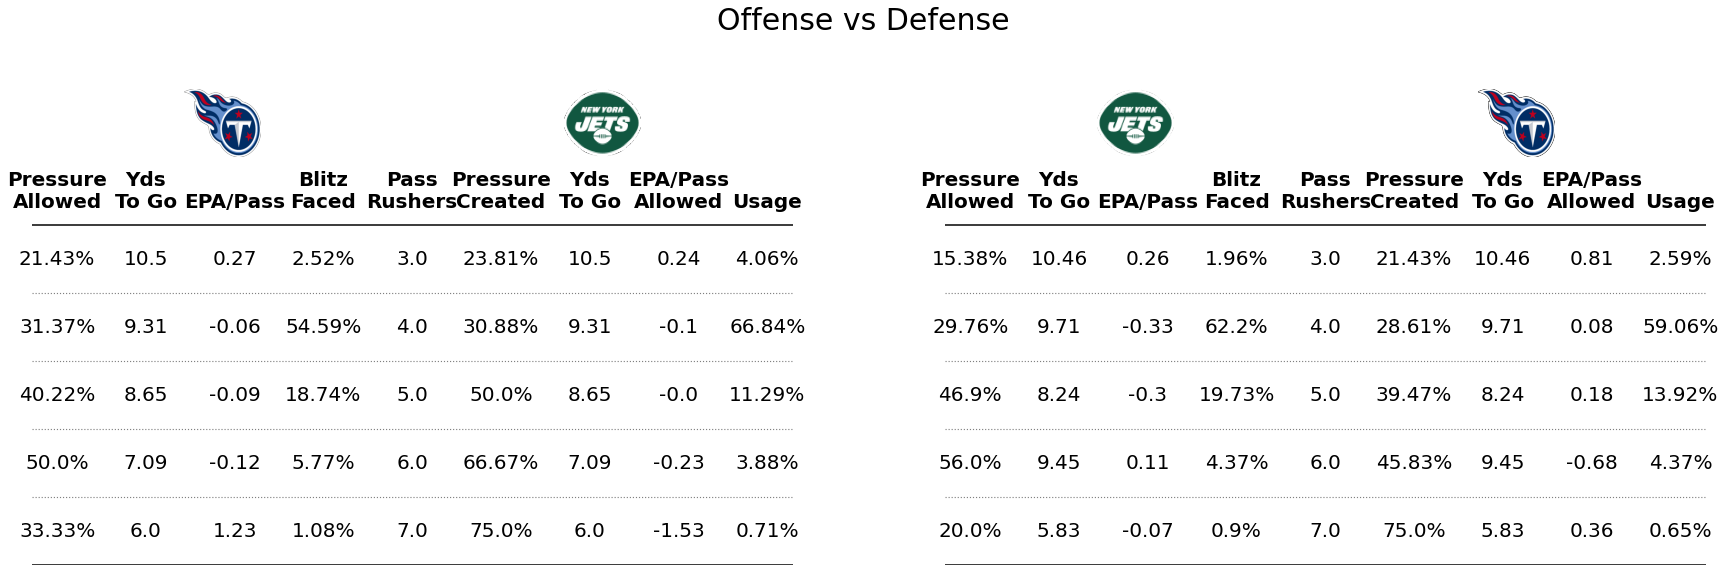

In [126]:
# fig = plt.figure(figsize=(7,5))
# plt.figure(facecolor='#ffff')
# ax = plt.subplot(1,1)
fig, ax = plt.subplots(1,2,figsize=(30,10),facecolor='#ffff')

for table_number,team in enumerate(team_name):
    
    
    plotting_df = final_df[final_df['posteam_off']==team].\
                        reset_index(drop=True).\
                        sort_index(ascending=False)

    color1 = '#FFFFFF'
    color2 = '#7C4D8B'

#     plotting_df['colors'] = get_color_gradient(color1, color2, len(plotting_df))

    ncols = 7
    nrows = plotting_df.shape[0]

    ax[table_number].set_xlim(0, 3)
    ax[table_number].set_ylim(0, nrows+3)

    positions = [0.1, 0.45, 0.8, 1.15, 1.5, 1.85, 2.2, 2.55, 2.9]
    columns = ['was_pressure_off','ydstogo_off','epa_off','blitz_percent_off','number_of_pass_rushers','was_pressure_def','ydstogo_def','epa_def','blitz_percent_def']

    # Add table's main text
    for i in range(nrows):
        for j, column in enumerate(columns):
            if j == 0:
                ha = 'center'
            else:
                ha = 'center'
            if (column == '') | (column == ''):
                text_label = f'{plotting_df[column].iloc[i]:,.2f}'
                weight = 'bold'
            else:
                text_label = f'{plotting_df[column].iloc[i]}'
                weight = 'normal'
            ax[table_number].annotate(
                xy=(positions[j], i+0.5),
                text=text_label,
                ha=ha,
                va='center',
                weight=weight,
                fontsize=20
            )
            
        # add logos
        if i == 0:
            a = plt.imread(plotting_df['team_logo_wikipedia_off'][i])
            ax[table_number].imshow(a, extent=[0.6, 0.9, nrows+1, nrows+2], aspect='auto', zorder=2)
            ax[table_number].annotate(
                    xy=(0.45, 3),
                    text='',
                    fontsize=40
                )
        else:
            a = plt.imread(plotting_df['team_logo_wikipedia_def'][i])
            ax[table_number].imshow(a, extent=[2.1, 2.4, nrows+1, nrows+2], aspect='auto', zorder=2)
            ax[table_number].annotate(
                    xy=(0.45, 3),
                    text='',
                    fontsize=40
                )
    # Add column names
    column_names = ['Pressure\nAllowed','Yds\nTo Go','EPA/Pass','Blitz\nFaced','Pass\nRushers','Pressure\nCreated','Yds\nTo Go','EPA/Pass\nAllowed','Usage']
    for index, c in enumerate(column_names):
            if index == 0:
                ha = 'center'
            else:
                ha = 'center'
            ax[table_number].annotate(
                xy=(positions[index], nrows+.2),
                text=column_names[index],
                ha=ha,
                va='bottom',
                weight='bold',
                fontsize=20
            )
    # ax.text(0.1, 9.75, 'Name', weight='bold', ha='left')
    # ax.text(0.56, 9.75, 'EPA/Play', weight='bold', ha='right')
    # ax.text(0.85, 9.75, 'Snaps', weight='bold', ha='right')
    # Add dividing lines
    ax[table_number].plot([ax[table_number].get_xlim()[0], 
                           ax[table_number].get_xlim()[1]], 
                          [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
    ax[table_number].plot([ax[table_number].get_xlim()[0], 
                           ax[table_number].get_xlim()[1]], 
                          [0, 0], lw=1.5, color='black', marker='', zorder=4)
    for x in range(1, nrows):
        ax[table_number].plot([ax[table_number].get_xlim()[0],
                               ax[table_number].get_xlim()[1]], 
                              [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')
    
    # use tuple for color  
    # loop through the rows for offense
#     for i in range(0,nrows):
#         ax[table_number].fill_between(
#             x=[0.07,0.13],
#             y1=i+1,
#             y2=i,
#             color=plt.cm.RdYlGn(plotting_df['value_percentile_off'][(i-5)*-1]),
#             alpha=0.5,
#             ec='None'
#         )
    # loop through the rows for defense
#     for i in range(0,nrows):
#         ax[table_number].fill_between(
#             x=[0.37,0.43],
#             y1=i+1,
#             y2=i,
#             color=plt.cm.RdYlGn(plotting_df['value_percentile_def'][(i-5)*-1]),
#             alpha=0.5,
#             ec='None'
#         )
    # ax.set_axis_off()

    ax[table_number].set_facecolor('#ffff') 
    plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 
#     ax[0].set_title('Offense vs Defense',loc='left',fontsize=30)
#     ax[1].set_title('Defense vs Offense',loc='left',fontsize=30)
    fig.suptitle('Offense vs Defense',fontsize=30,y=0.9,x=0.51)

    ax[table_number].set_axis_off()
    
plt.savefig(
    './BlitzPackages.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

# color by ranking in league?